In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from math import isnan

In [2]:
data = dict()
data["fake"]  = pd.read_csv("DATASET/fusers.csv")
data["legit"] = pd.read_csv("DATASET/users.csv")

In [3]:
data["legit"] = data["legit"].drop(["id", "name", "screen_name", "statuses_count", "created_at", "lang", "location", "geo_enabled", "default_profile_image", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated"], axis=1)
data["fake"]  = data["fake"].drop(["id", "name", "screen_name", "statuses_count", "created_at", "lang", "location", "geo_enabled", "default_profile_image", "profile_image_url", "profile_banner_url", "profile_use_background_image", "profile_background_image_url_https", "profile_text_color", "profile_image_url_https", "profile_sidebar_border_color", "profile_background_tile", "profile_sidebar_fill_color", "profile_background_image_url", "profile_background_color", "profile_link_color", "utc_offset", "protected", "verified", "dataset", "updated"], axis=1)

In [4]:
def is_default_profile(arr):
    ret = []
    for l in arr:
        if l == 1.:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def has_description(arr):
    ret = []
    for l in arr:
        if type(l) == str:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def has_url(arr):
    ret = []
    for l in arr:
        if type(l) == str and len(l) > 0:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def has_timezone(arr):
    ret = []
    for l in arr:
        if type(l) == str and len(l) > 0:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def is_listed(arr):
    ret = []
    for l in arr:
        if l > 0.:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def has_favourites(arr):
    ret = []
    for l in arr:
        if l > 0.:
            ret.append(1.)
        else:
            ret.append(-1.)
    return ret

def friends_followers_ratio(friends, followers):
    ret = []
    for fr, fo in zip(friends, followers):
        if isnan(fo) or fo == 0.:
            ret.append(-1.)
        else:
            ret.append(fr/fo)
    return ret

In [5]:
data["legit"]["fr_fo"] = friends_followers_ratio(data["legit"]["friends_count"], data["legit"]["followers_count"])
data["legit"]["has_fav"] = has_favourites(data["legit"]["favourites_count"])
data["legit"]["is_listed"] = is_listed(data["legit"]["listed_count"])
data["legit"]["url"] = has_url(data["legit"]["url"])
data["legit"]["time_zone"] = has_timezone(data["legit"]["time_zone"])
data["legit"]["default_profile"] = is_default_profile(data["legit"]["default_profile"])
data["legit"]["description"] = has_description(data["legit"]["description"])

data["fake"]["fr_fo"] = friends_followers_ratio(data["fake"]["friends_count"], data["fake"]["followers_count"])
data["fake"]["has_fav"] = has_favourites(data["fake"]["favourites_count"])
data["fake"]["is_listed"] = is_listed(data["fake"]["listed_count"])
data["fake"]["url"] = has_url(data["fake"]["url"])
data["fake"]["time_zone"] = has_timezone(data["fake"]["time_zone"])
data["fake"]["default_profile"] = is_default_profile(data["fake"]["default_profile"])
data["fake"]["description"] = has_description(data["fake"]["description"])


In [6]:
data["legit"].drop(["followers_count", "friends_count", "favourites_count", "listed_count"],axis=1, inplace=True)
data["fake"].drop(["followers_count", "friends_count", "favourites_count", "listed_count"],axis=1, inplace=True)

In [7]:
print("Final Available Columns ", len(data["legit"].columns))
data["legit"].columns

Final Available Columns  7


Index(['url', 'time_zone', 'default_profile', 'description', 'fr_fo',
       'has_fav', 'is_listed'],
      dtype='object')

In [8]:
print(f"number of legit accounts : {len(data['legit'])}")
print(f"number of fake accounts  : {len(data['fake'])}")

number of legit accounts : 1481
number of fake accounts  : 1337


In [9]:
data["legit"] = data["legit"].values
data["fake"] = data["fake"].values

In [10]:
data["legit"] = data["legit"].astype(np.float64)
data["fake"] = data["fake"].astype(np.float64)

In [11]:
import math

def get_class_weights(labels):
    n_classes = len(labels[0])
    class_counts = [0 for _ in range(int(n_classes))]
    for label in labels:
        class_counts[label.index(1)] += 1
    return {i : (1. / class_counts[i]) * float(len(labels)) / float(n_classes) for i in range(int(n_classes))}

In [12]:
X = []
Y = []
# legit -> [1.,0.]
# fake -> [0.,1.]

for row in data["legit"]:
    X.append(row)
    Y.append([1.,0.])
    
for row in data["fake"]:
    X.append(row)
    Y.append([0.,1.])

X = np.array(X)
Y = np.array(Y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, 
    test_size=0.24, random_state=42)

class_weights = get_class_weights(y_train.tolist())
class_weights

{0: 0.9532502226179875, 1: 1.0515717092337917}

In [14]:
import tensorflow as tf

In [15]:
x = tf.keras.Input((7))
y = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer="l2")(x)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(8, activation="relu", kernel_regularizer="l2")(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dense(2, activation="softmax", kernel_regularizer="l2")(y)
model = tf.keras.models.Model(x, y)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 378
Trainable params: 330
Non-trainable params: 48
______________________________________________________________

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss', factor=0.5, patience=10,
          min_delta=0.0001, verbose=1)

In [17]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), shuffle=True, batch_size=128, callbacks=[early_stopping,reduceLR_cb], class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
17/17 [==============================] - 8s 139ms/step - loss: 0.5747 - acc: 0.9014 - val_loss: 0.6280 - val_acc: 0.8287
Epoch 2/200
17/17 [==============================] - 0s 19ms/step - loss: 0.4647 - acc: 0.9313 - val_loss: 0.5532 - val_acc: 0.9069
Epoch 3/200
17/17 [==============================] - 0s 14ms/step - loss: 0.3900 - acc: 0.9491 - val_loss: 0.4954 - val_acc: 0.9439
Epoch 4/200
17/17 [==============================] - 0s 24ms/step - loss: 0.3309 - acc: 0.9696 - val_loss: 0.4314 - val_acc: 0.9631
Epoch 5/200
17/17 [==============================] - 0s 16ms/step - loss: 0.2892 - acc: 0.9846 - val_loss: 0.3795 - val_acc: 0.9690
Epoch 6/200
17/17 [==============================] - 0s 19ms/step - loss: 0.2642 - acc: 0.9846 - val_loss: 0.3446 - val_acc: 0.9764
Epoch 7/200
17/17 [==============================] - 0s 21ms/step - l

17/17 [==============================] - 0s 14ms/step - loss: 0.0543 - acc: 0.9953 - val_loss: 0.0552 - val_acc: 0.9970
Epoch 60/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0522 - acc: 0.9953 - val_loss: 0.0542 - val_acc: 0.9956
Epoch 61/200
17/17 [==============================] - 0s 15ms/step - loss: 0.0518 - acc: 0.9958 - val_loss: 0.0586 - val_acc: 0.9956
Epoch 62/200
17/17 [==============================] - 0s 14ms/step - loss: 0.0523 - acc: 0.9944 - val_loss: 0.0532 - val_acc: 0.9970
Epoch 63/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0521 - acc: 0.9944 - val_loss: 0.0577 - val_acc: 0.9926
Epoch 64/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0519 - acc: 0.9949 - val_loss: 0.0543 - val_acc: 0.9970
Epoch 65/200
17/17 [==============================] - 0s 16ms/step - loss: 0.0503 - acc: 0.9953 - val_loss: 0.0511 - val_acc: 0.9941
Epoch 66/200
17/17 [==============================] - 0s 17ms/step - loss: 0.0477 

In [18]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 6ms/step - loss: 0.0371 - acc: 0.9985


[0.03713151440024376, 0.9985228776931763]

In [19]:
preds = model.predict(X_test)

In [20]:
conf = confusion_matrix(np.argmax(y_test,-1), np.argmax(preds,-1))
conf

array([[358,   0],
       [  1, 318]], dtype=int64)

In [21]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Legit','Fake']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

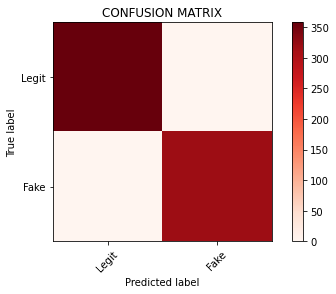

In [22]:
plot_confusion_matrix(conf)

In [23]:
model.save("./model/classifier_2.h5")